# 1 day

In [11]:
import numpy as np
import pandas as pd
import netCDF4 as nc4
from netCDF4 import num2date
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from netCDF4 import Dataset

In [12]:
# Rutas
ncFileName = '/disk/barbusano/barbusano1/Projects/Waves/IAwave/Tania_TFG/Datos/Datos_Albano_Modelo/wave_wind_20_23_filtered_3y.nc'
csvFileName = '/disk/barbusano/barbusano1/Projects/Waves/IAwave/Tania_TFG/Datos/Boya Tenerife Sur/DailyWaveStats_4p_20_23_TS.csv'

# Leer NetCDF
with nc4.Dataset(ncFileName, mode='r') as ncfid:
    time = ncfid.variables['valid_time'][:]
    u10 = ncfid.variables['u10'][:]  # (time, lat, lon)
    v10 = ncfid.variables['v10'][:]

    time_units = ncfid.variables['valid_time'].units
    time_calendar = getattr(ncfid.variables['valid_time'], 'calendar', 'standard')
    time_dates = num2date(time, units=time_units, calendar=time_calendar)
    time_dates_dt = [datetime(date.year, date.month, date.day) for date in time_dates]

# Extraer componente u y v en punto (93, 88)
u_point = u10[:, 93, 88]
v_point = v10[:, 93, 88]

# Calcular dirección del viento (en grados meteorológicos: desde donde sopla)
wind_dir = (np.degrees(np.arctan2(u_point, v_point)) + 180) % 360

# Crear DataFrame viento
df_nc = pd.DataFrame({'Fecha': time_dates_dt})
df_nc['wind_dir'] = wind_dir
df_nc.set_index('Fecha', inplace=True)

# Leer CSV boya
df = pd.read_csv(csvFileName, sep=',', decimal='.', encoding='utf-8')
df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True)
df_boya = df[['Fecha', 'Dir_procedencia_mean']]

# Combinar
df_merged = pd.merge(df_boya, df_nc, left_on='Fecha', right_index=True)
df_merged.dropna(inplace=True)

# Extraer ángulos
wind_angles = df_merged['wind_dir'].values
wave_angles = df_merged['Dir_procedencia_mean'].values

/disk/barbusano/barbusano1/Projects/Waves/IAwave/lib64/python3.9/site-packages/numpy/_core/fromnumeric.py:820: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


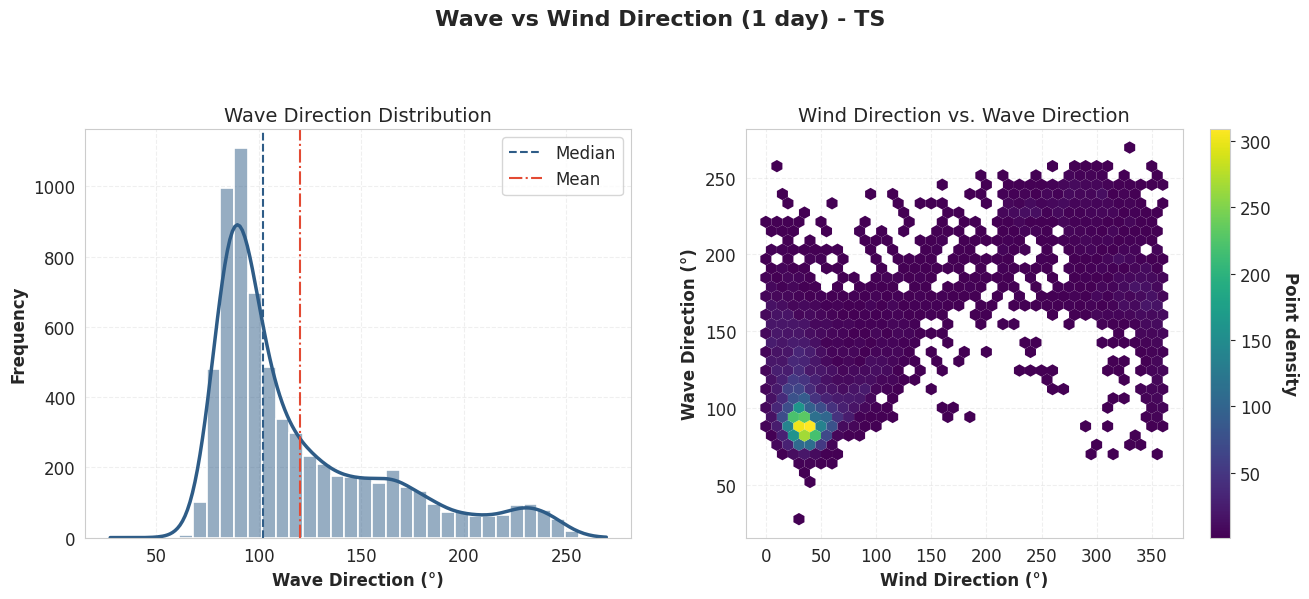

In [13]:

# Gráfica
fig = plt.figure(figsize=(14, 6))
fig.suptitle('Wave vs Wind Direction (1 day) - TS', fontsize=16, fontweight='bold', y=1.05)

# Histograma de dirección de ola
ax1 = plt.subplot(1, 2, 1)
sns.histplot(
    x=wave_angles,
    bins=36,
    kde=True,
    color='#2e5c87',
    edgecolor='white',
    linewidth=1.2,
    ax=ax1,
    line_kws={'color': '#e34a33', 'linewidth': 2.5, 'linestyle': '-'}
)
ax1.axvline(np.median(wave_angles), color='#2e5c87', linestyle='--', label='Median')
ax1.axvline(np.mean(wave_angles), color='#e34a33', linestyle='-.', label='Mean')
ax1.set_title("Wave Direction Distribution")
ax1.set_xlabel("Wave Direction (°)")
ax1.set_ylabel("Frequency")
ax1.legend()
ax1.grid(alpha=0.3)

# Hexbin: dirección del viento vs dirección de ola
ax2 = plt.subplot(1, 2, 2)
hb = ax2.hexbin(
    wind_angles,
    wave_angles,
    gridsize=36,
    cmap='viridis',
    mincnt=1,
    edgecolors='none'
)
cbar = plt.colorbar(hb, ax=ax2)
cbar.set_label('Point density', rotation=270, labelpad=20)
ax2.set_title("Wind Direction vs. Wave Direction")
ax2.set_xlabel("Wind Direction (°)")
ax2.set_ylabel("Wave Direction (°)")
ax2.grid(alpha=0.3)

plt.tight_layout(pad=3)
plt.subplots_adjust(top=0.85)
plt.savefig('direction_relation_1day.png', dpi=300, bbox_inches='tight')
plt.show()

# 6 days

In [14]:
# Archivo NetCDF con 6 días
nc_path = '/disk/barbusano/barbusano1/Projects/Waves/IAwave/Tania_TFG/Datos/Datos_Albano_Modelo/wave_wind_2000_2023_128x128_filtered_tfs_5days.nc'

# Leer datos de viento y calcular dirección
with Dataset(nc_path, mode='r') as ncfile:
    wind_dirs = []
    for day in range(6):  # u0 a u5, v0 a v5
        u = ncfile.variables[f'u{day}'][:, 93, 88]
        v = ncfile.variables[f'v{day}'][:, 93, 88]
        dir_day = (np.degrees(np.arctan2(u, v)) + 180) % 360  # Dirección meteorológica
        wind_dirs.append(dir_day)

    wind_dirs_stack = np.stack(wind_dirs, axis=1)  # shape (n_samples, 6)

    # Media circular de la dirección del viento en grados
    wind_rad = np.deg2rad(wind_dirs_stack)
    mean_sin = np.mean(np.sin(wind_rad), axis=1)
    mean_cos = np.mean(np.cos(wind_rad), axis=1)
    wind_dir_mean = (np.degrees(np.arctan2(mean_sin, mean_cos)) + 360) % 360

# Leer CSV con datos de dirección de oleaje
csv_path = '/disk/barbusano/barbusano1/Projects/Waves/IAwave/Tania_TFG/Datos/Boya Tenerife Sur/DailyWaveStats_4p_20_23_TS.csv'
df_wave = pd.read_csv(csv_path, sep=',', decimal='.', encoding='utf-8')
df_wave['Fecha'] = pd.to_datetime(df_wave['Fecha'], dayfirst=True)
direction = df_wave['Dir_procedencia_mean'].astype(float).values

# Alinear tamaños
min_len = min(len(wind_dir_mean), len(direction))
direction = direction[:min_len]
wind_dir_mean = wind_dir_mean[:min_len]


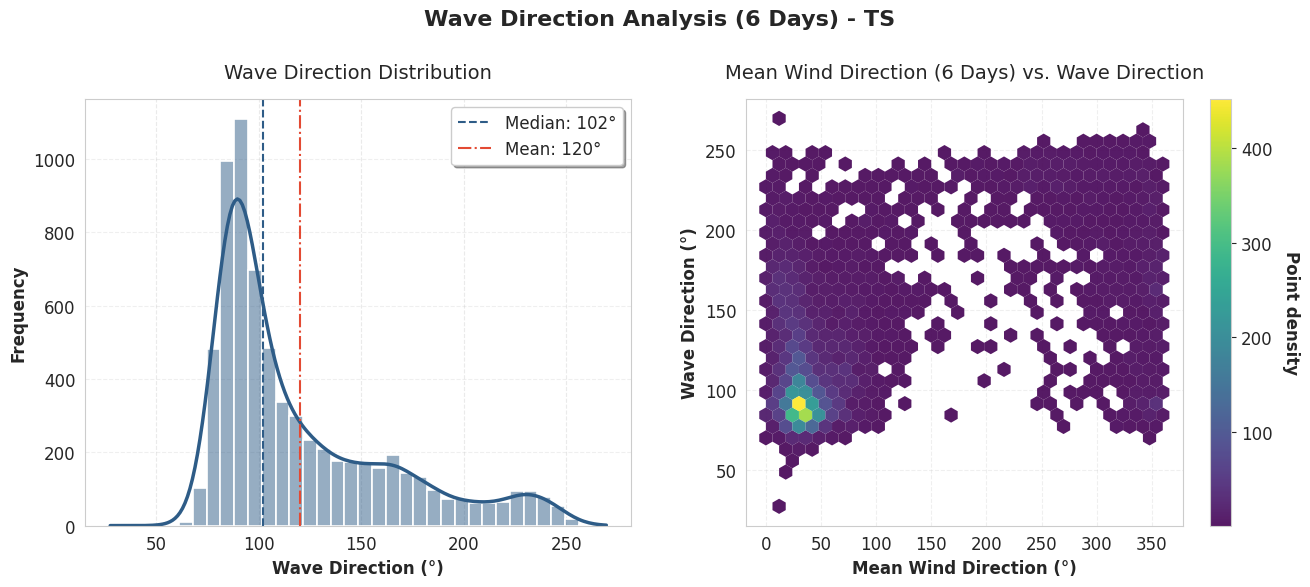

In [15]:
# Estilo general
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelweight': 'bold',
    'grid.linestyle': '--',
    'grid.alpha': 0.4,
    'figure.facecolor': 'white'
})

# Figura conjunta
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Wave Direction Analysis (6 Days) - TS', fontsize=16, fontweight='bold', y=1.03)

# Histograma + KDE de dirección de oleaje
sns.histplot(
    x=direction,
    bins=36,
    kde=True,
    color='#2e5c87',
    edgecolor='white',
    linewidth=1.2,
    line_kws={'color': '#e34a33', 'linewidth': 2.5},
    ax=ax1
)
median = np.median(direction)
mean = np.mean(direction)
ax1.axvline(median, color='#2e5c87', linestyle='--', linewidth=1.5,
            label=f'Median: {median:.0f}°')
ax1.axvline(mean, color='#e34a33', linestyle='-.', linewidth=1.5,
            label=f'Mean: {mean:.0f}°')
ax1.set_title("Wave Direction Distribution", pad=15)
ax1.set_xlabel("Wave Direction (°)", fontweight='semibold')
ax1.set_ylabel("Frequency", fontweight='semibold')
ax1.legend(frameon=True, shadow=True, loc='upper right')
ax1.grid(axis='y', alpha=0.3)

# Hexbin: dirección media del viento vs dirección del oleaje
hexbin = ax2.hexbin(
    wind_dir_mean,
    direction,
    gridsize=30,
    cmap='viridis',
    mincnt=1,
    edgecolors='none',
    alpha=0.9
)
cbar = plt.colorbar(hexbin, ax=ax2)
cbar.set_label('Point density', rotation=270, labelpad=20, fontweight='semibold')

ax2.set_title("Mean Wind Direction (6 Days) vs. Wave Direction", pad=15)
ax2.set_xlabel("Mean Wind Direction (°)", fontweight='semibold')
ax2.set_ylabel("Wave Direction (°)", fontweight='semibold')
ax2.grid(alpha=0.3)

# Ajustes finales
plt.tight_layout(pad=3)
plt.subplots_adjust(top=0.88)
plt.savefig('direction_relation_6days.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Valor Real csv vs. Valor Modelo nCDF

In [26]:
# Rutas de los archivos
ncFileName = '/disk/barbusano/barbusano1/Projects/Waves/IAwave/Tania_TFG/Datos/Datos_Albano_Modelo/wave_wind_2000_2023_128x128_filtered_tfs_5days.nc'
csvFileName = '/disk/barbusano/barbusano1/Projects/Waves/IAwave/Tania_TFG/Datos/Boya Tenerife Sur/DailyWaveStats_4p_20_23_TS.csv'

# --- Leer datos del modelo ---
with Dataset(ncFileName, mode='r') as ncfid:
    time = ncfid.variables['valid_time'][:]
    lat = ncfid.variables['latitude'][:]
    lon = ncfid.variables['longitude'][:]
    mwd0 = ncfid.variables['mwd0'][:]  # modelo: wave direction día 0

    # Convertir tiempo a fechas
    time_units = ncfid.variables['valid_time'].units
    time_calendar = ncfid.variables['valid_time'].calendar if hasattr(ncfid.variables['valid_time'], 'calendar') else 'standard'
    time_dates = num2date(time, units=time_units, calendar=time_calendar)
    time_dates_dt = [datetime(d.year, d.month, d.day) for d in time_dates]

# Posición de la boya (93, 88)
df_model_dir = pd.DataFrame({
    'Fecha': pd.to_datetime(time_dates_dt),
    'dir_model': mwd0[:, 93, 88]
})
df_model_dir.set_index('Fecha', inplace=True)

# --- Leer CSV de la boya ---
df_boya = pd.read_csv(csvFileName, sep=',', decimal='.', encoding='utf-8')
df_boya['Fecha'] = pd.to_datetime(df_boya['Fecha'], dayfirst=True)

df_boya_dir = df_boya[['Fecha', 'Dir_procedencia_mean']].copy()
df_boya_dir.rename(columns={'Dir_procedencia_mean': 'dir_real'}, inplace=True)
df_boya_dir.set_index('Fecha', inplace=True)

# --- Merge por fecha ---
df_comp_dir = pd.merge(df_boya_dir, df_model_dir, left_index=True, right_index=True)

# Verificación
print(df_comp_dir.head())
print(f"Shape: {df_comp_dir.shape}")

            dir_real  dir_model
Fecha                          
2003-05-06      87.0  62.515842
2003-05-07      88.5  28.429190
2003-05-08      89.0  25.123377
2003-05-09      89.5  19.245296
2003-05-10      93.0  11.689082
Shape: (6879, 2)


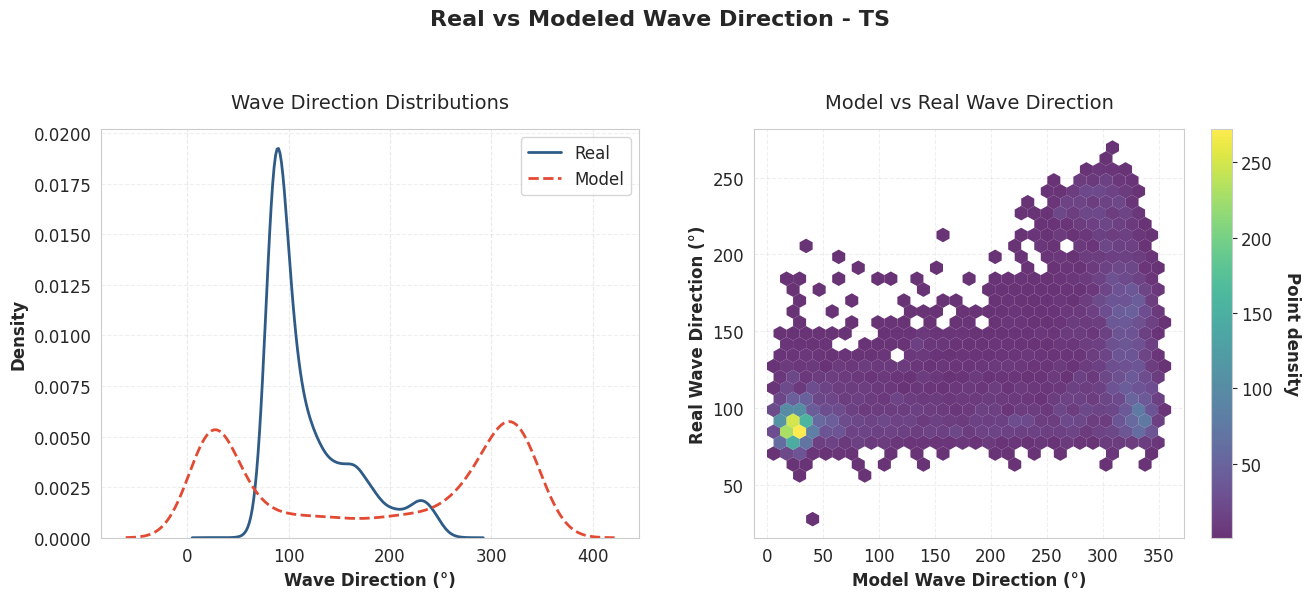

In [27]:
# --- Estilo gráfico ---
sns.set_style("whitegrid")
sns.set_palette("Set2")
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelweight': 'bold',
    'grid.linestyle': '--',
    'grid.alpha': 0.4,
    'figure.facecolor': 'white'
})

# --- Figura comparativa ---
fig = plt.figure(figsize=(14, 6))
fig.suptitle('Real vs Modeled Wave Direction - TS', fontsize=16, fontweight='bold', y=1.05)

# KDE (curvas de densidad)
ax1 = plt.subplot(1, 2, 1)
sns.kdeplot(df_comp_dir['dir_real'], label='Real', color='#2e5c87', linewidth=2)
sns.kdeplot(df_comp_dir['dir_model'], label='Model', color='#e34a33', linewidth=2, linestyle='--')

ax1.set_title("Wave Direction Distributions", pad=15)
ax1.set_xlabel("Wave Direction (°)", fontweight='semibold')
ax1.set_ylabel("Density", fontweight='semibold')
ax1.legend(frameon=True, loc='upper right')
ax1.grid(axis='y', alpha=0.3)

# Hexbin scatter: model vs real
ax2 = plt.subplot(1, 2, 2)
hexbin = ax2.hexbin(
    df_comp_dir['dir_model'],
    df_comp_dir['dir_real'],
    gridsize=30,
    cmap='viridis',
    mincnt=1,
    edgecolors='none',
    alpha=0.8
)

cbar = plt.colorbar(hexbin, ax=ax2)
cbar.set_label('Point density', rotation=270, labelpad=20, fontweight='semibold')

ax2.set_title("Model vs Real Wave Direction", pad=15)
ax2.set_xlabel("Model Wave Direction (°)", fontweight='semibold')
ax2.set_ylabel("Real Wave Direction (°)", fontweight='semibold')
ax2.grid(alpha=0.3)

# --- Finalización ---
plt.tight_layout(pad=3)
plt.subplots_adjust(top=0.85)
plt.savefig('real_vs_model_wave_direction.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
